<a href="https://colab.research.google.com/github/investigapyrm/sesgoenerrormuestreo/blob/main/sesgomuestreo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Coberturas observadas (proporción de IC que contienen p=0.5):
metodo
Determinista    0.0671
MAS             0.9336


/tmp/ipykernel_5836/1515274362.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


Figura guardada en /workspaces/sesgoenerrormuestreo/intervalos_ic.png


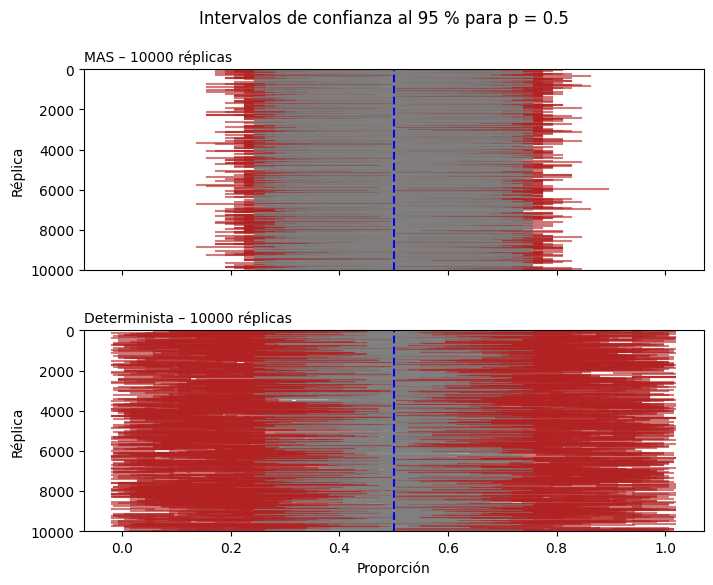

In [1]:
#!/usr/bin/env python3
"""simulacion_ic_python.py

Simula 10 000 intervalos de confianza (95 %) para una proporción p = 0.5
bajo dos diseños de muestreo:
    1) Muestreo aleatorio simple (MAS)
    2) Muestra determinista basada en una función lineal (pendiente m y
       intercepto b aleatorios por réplica)

El script genera:
  * DataFrame con resultados (método, réplica, p_hat, lo, hi, contiene)
  * Métricas de cobertura impresas en pantalla
  * Figura PNG (`intervalos_ic.png`) que superpone los IC de ambos métodos

Uso:
    $ python simulacion_ic_python.py
Requiere: numpy, pandas, matplotlib
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------- Parámetros del experimento --------------------
R = 10_000   # número de réplicas por método
n = 50       # tamaño muestral
p_true = 0.5 # parámetro poblacional
z = 1.96     # cuantíl normal 0.975

rng = np.random.default_rng(123)

# -------------------- Contenedor de resultados ----------------------
records = []  # cada ítem: (metodo, replica, p_hat, lo, hi, contiene)

# -------------------- Simulación MAS -------------------------------
for r in range(1, R + 1):
    y = rng.binomial(1, p_true, size=n)
    p_hat = y.mean()
    se = np.sqrt(p_hat * (1 - p_hat) / n)
    lo, hi = p_hat - z * se, p_hat + z * se
    records.append(("MAS", r, p_hat, lo, hi, lo <= p_true <= hi))

# -------------------- Simulación determinista ----------------------
i = np.arange(1, n + 1)
for r in range(1, R + 1):
    m = rng.uniform(-0.05, 0.05)
    b = rng.uniform(-2.5, 2.5)
    y_det = (m * i + b > 0).astype(int)
    p_hat = y_det.mean()
    se = np.sqrt(p_hat * (1 - p_hat) / n)
    lo, hi = p_hat - z * se, p_hat + z * se
    records.append(("Determinista", r, p_hat, lo, hi, lo <= p_true <= hi))

# -------------------- DataFrame final -------------------------------
cols = ["metodo", "replica", "p_hat", "lo", "hi", "contiene"]
df = pd.DataFrame.from_records(records, columns=cols)

# -------------------- Cobertura observada ---------------------------
print("Coberturas observadas (proporción de IC que contienen p=0.5):")
print(df.groupby("metodo")["contiene"].mean().to_string())

# -------------------- Gráfico de intervalos -------------------------
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                         gridspec_kw={"hspace": 0.3})
metodos = ["MAS", "Determinista"]
colors = {True: "grey", False: "firebrick"}

for ax, metodo in zip(axes, metodos):
    sub = df[df["metodo"] == metodo].reset_index(drop=True)
    y_positions = np.arange(len(sub))
    for idx, row in sub.iterrows():
        ax.plot([row.lo, row.hi], [idx, idx],
                color=colors[row.contiene], alpha=0.6)
    ax.axvline(p_true, color="blue", ls="--")
    ax.set_title(f"{metodo} – {R} réplicas", loc="left", fontsize=10)
    ax.set_ylabel("Réplica")
    ax.set_ylim(-1, len(sub))
    ax.invert_yaxis()

axes[-1].set_xlabel("Proporción")
fig.suptitle("Intervalos de confianza al 95 % para p = 0.5", fontsize=12)

# Guardar figura
out_png = Path("intervalos_ic.png")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(out_png, dpi=300)
print(f"Figura guardada en {out_png.resolve()}")

# --------------------------------------------------------------------


In [ ]:
'''
latexmk -pdf -quiet reporte.tex      
# o, si prefieres,                  
pdflatex reporte.tex && bibtex reporte && pdflatex reporte.tex && pdflatex reporte.tex
'''